
--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.79      0.96      0.87      1035
           1       0.72      0.30      0.43       374

    accuracy                           0.78      1409
   macro avg       0.76      0.63      0.65      1409
weighted avg       0.77      0.78      0.75      1409


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.66      0.47      0.55       374

    accuracy                           0.80      1409
   macro avg       0.75      0.69      0.71      1409
weighted avg       0.78      0.80      0.78      1409



c:\Users\soura\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:22:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost ---
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.58      0.50      0.54       374

    accuracy                           0.77      1409
   macro avg       0.71      0.68      0.69      1409
weighted avg       0.76      0.77      0.77      1409



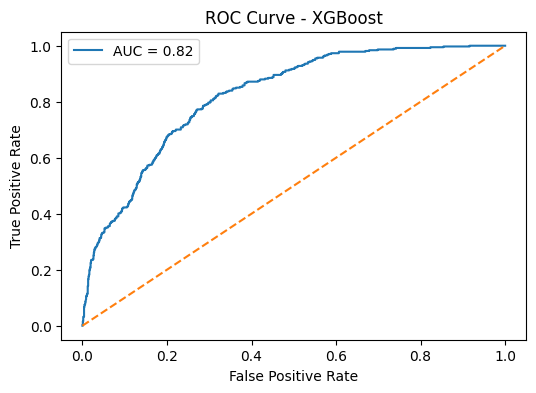

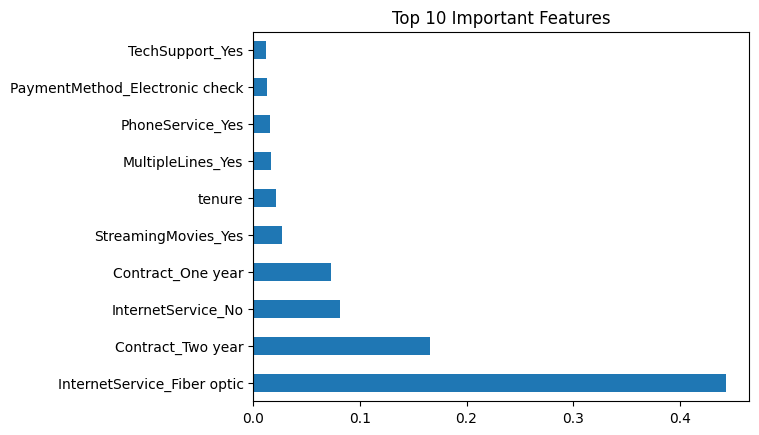

Model training complete and saved.


In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib
import os

# Create folder to save model if not exists
os.makedirs("model", exist_ok=True)

# Load Cleaned Data
df = pd.read_csv("cleaned_telco_churn.csv")

# Encode Target Variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Save customerID for later use if exists, else create index
if 'customerID' in df.columns:
    customer_ids = df['customerID']
else:
    customer_ids = df.index

# Encode Categorical Variables (excluding 'Churn' and 'customerID')
cols_to_encode = df.drop(['Churn'] + (['customerID'] if 'customerID' in df.columns else []), axis=1).select_dtypes(include=['object']).columns
df_encoded = pd.get_dummies(df.drop(['Churn'] + (['customerID'] if 'customerID' in df.columns else []), axis=1), drop_first=True)

X = df_encoded
y = df['Churn']

# Train/Test Split
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, y, customer_ids, test_size=0.2, random_state=42, stratify=y)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)
y_pred_lr = logreg.predict(X_test_scaled)

print("\n--- Logistic Regression ---")
print(classification_report(y_test, y_pred_lr))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n--- Random Forest ---")
print(classification_report(y_test, y_pred_rf))

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("\n--- XGBoost ---")
print(classification_report(y_test, y_pred_xgb))

# ROC Curve for best model (XGBoost)
y_proba = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.show()

# Feature Importance
feat_importances = pd.Series(xgb.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.show()

# Save Model and Scaler
joblib.dump(xgb, 'model/xgb_churn_model.pkl')
joblib.dump(scaler, 'model/scaler.pkl')

print("Model training complete and saved.")

# ------------------------------------
# Identify Customers Predicted to Churn
# ------------------------------------

# Create DataFrame with IDs, true label, predicted label, and predicted probability
results = pd.DataFrame({
    'customerID': id_test,
    'ActualChurn': y_test,
    'PredictedChurn': y_pred_xgb,
    'ChurnProbability': y_proba
})

# Customers predicted to churn
customers_likely_to_churn = results[results['PredictedChurn'] == 1].sort_values(by='ChurnProbability', ascending=False)

print("\nCustomers predicted to churn (top 10):")
print(customers_likely_to_churn.head(10))

# Optionally save to CSV
customers_likely_to_churn.to_csv('customers_likely_to_churn.csv', index=False)
